In [13]:
# imports
import astropy.table as apTab
import astropy.units as u
from itertools import chain
from lsst.analysis.tools.math import nanSigmaMad
import lsst.daf.butler as dafButler
import matplotlib.pyplot as plt
import numpy as np
import os


In [2]:
# butlers
is_ci = False
models = ("ser", "ser_fixedcen")
collections = {model: f"u/dtaranu/DM-42157/fit_ugrizy_match_{model}" for model in models}
if is_ci:
    skymap="discrete/ci_imsim/4k"
    patch=24
    tract=0
    repo = f"{os.environ['CI_IMSIM_DIR']}/DATA"
else:
    skymap = "DC2"
    tract = 3828
    patch = 24
    repo = "/repo/dc2"
butlers = {
    model: dafButler.Butler(repo, skymap=skymap, collections=[collection])
    for model, collection in collections.items()
}

In [12]:
# load data
band = "r"
mag_max = 20.0 + 2.0*is_ci
scale_pix = 0.2

schema_obj = tuple(chain(
    *(
        (f"{band}_bdFluxB", f"{band}_bdFluxD", f"{band}_bdReB", f"{band}_bdReD")
        for band in "ugrizy"
    ),
))

matched = {
    model: (
        butler.get(
            "matched_truth_summary_objectTable_tract_multiprofit",
            tract=tract,
            storageClass="ArrowAstropy",
        ),
        None,
    )
    for model, butler in butlers.items()
}
matched["cmodel"] = (
    butlers[models[0]].get(
        "matched_truth_summary_objectTable_tract", tract=tract, storageClass="ArrowAstropy",
    ),
    butlers[models[0]].get(
        "objectTable_tract", tract=tract, storageClass="ArrowAstropy", parameters={"columns": schema_obj},
    ),
)

In [26]:
# function to select subset of data
def get_bright(matched, scale_pix, mag_minmax, is_pointsource=None, extended_minmax=None):
    bright = {}
    for model, (table, table_join) in matched.items():
        is_cmodel = model == "cmodel"
        cond = u.nanojansky.to(u.ABmag, table[f"refcat_flux_{band}"])
        cond = (cond >= mag_minmax[0]) & (cond <= mag_minmax[1])
        if is_pointsource is not None:
            cond &= table["refcat_is_pointsource"] == is_pointsource
        if extended_minmax is not None:
            extendedness = table["refExtendedness"]
            cond &= (extendedness >= extended_minmax[0]) & (extendedness <= extended_minmax[1]) 
        subset = table[cond]
        if table_join is not None:
            subset = apTab.join(subset, table_join, join_type="inner", keys="objectId")
        subset[f"refcat_mag_{band}"] = u.nanojansky.to(u.ABmag, subset[f"refcat_flux_{band}"])
        subset[f"model_mag_{band}"] = u.nanojansky.to(u.ABmag, subset[f"{band}_cModelFlux" if is_cmodel else f"mpf_{model}_{band}_flux"])
        subset["diff_ra"] = 1000*scale_pix*(subset["refcat_x"] - subset["x"]) if is_cmodel else 3600000*(
            subset["refcat_ra"] - subset[f"mpf_{model}_cen_ra"])
        subset["diff_dec"] = 1000*scale_pix*(subset["refcat_y"] - subset["y"]) if is_cmodel else 3600000*(
            subset["refcat_dec"] - subset[f"mpf_{model}_cen_dec"])
        subset["dist"] = np.hypot(subset["diff_ra"], subset["diff_dec"])
        subset["size"] = np.log10(scale_pix*(
            np.hypot(
                subset[f"{band}_bdFluxB"]*subset[f"{band}_bdReB"],
                subset[f"{band}_bdFluxD"]*subset[f"{band}_bdReD"]
            )/(subset[f"{band}_bdFluxB"] + subset[f"{band}_bdFluxD"]) if is_cmodel else
            np.hypot(subset[f"mpf_{model}_ser_reff_x"], subset[f"mpf_{model}_ser_reff_x"])
        ))
        bright[model] = subset
    return bright

In [34]:
# function to make scatter plots of diffs
def make_scatterplots(bright, lims_dist=(0, 100.), lims_mag_diff=(-500, 500), lims_log_size=(-2.5, 1.5)):
    kwargs_fig = dict(ncols=2, nrows=2, width_ratios=[0.8, 0.2], height_ratios=[0.2, 0.8], figsize=(12, 12))
    fig_dist_dmag, ax_dist_dmag = plt.subplots(**kwargs_fig)
    fig_mag_dmag, ax_mag_dmag = plt.subplots(**kwargs_fig)
    fig_mag_dra, ax_mag_dra = plt.subplots(**kwargs_fig)
    fig_mag_ddec, ax_mag_ddec = plt.subplots(**kwargs_fig)
    fig_mag_size, ax_mag_size = plt.subplots(**kwargs_fig)
    
    axes_dist = (ax_dist_dmag,)
    axes_mag = (ax_mag_dmag, ax_mag_dra, ax_mag_ddec, ax_mag_size)
    axes_all = axes_dist + axes_mag
    
    kwargs_hist = {"histtype": "step", "log": True}
    lims_dradec = (-lims_dist[1], lims_dist[1])
    lims_mag = (16, mag_max)
    n_bins = 50
    
    for model, subset in bright.items():
        mag_true = subset[f"refcat_mag_{band}"]
        diff_mag = 1000*(subset[f"model_mag_{band}"] - mag_true)
        mag_true = np.clip(mag_true, lims_mag[0], lims_mag[1])
        diff_ra = subset["diff_ra"]
        diff_dec = subset["diff_dec"]
        print(
            f"{model:<12} N={len(diff_mag)} med,sig_mad_mag={np.nanmedian(diff_mag):.1f}, {nanSigmaMad(diff_mag):.1f} mmag"
            f" med,sig_mad_ra={np.nanmedian(diff_ra):.2f},{nanSigmaMad(diff_ra):.2f} mas "
            f" med,sig_mad_dec={np.nanmedian(diff_dec):.2f},{nanSigmaMad(diff_dec):.2f} mas"
        )
        diff_mag = np.clip(diff_mag, lims_mag_diff[0], lims_mag_diff[1])
        diff_ra = np.clip(diff_ra, lims_dradec[0], lims_dradec[1])
        diff_dec = np.clip(diff_dec, lims_dradec[0], lims_dradec[1])
        dists = np.clip(subset["dist"], lims_dist[0], lims_dist[1])
        size = np.clip(subset["size"], lims_log_size[0], lims_log_size[1])
        # Could join and connect here, but it's a bit busy
        ax_dist_dmag[1][0].scatter(dists, diff_mag, label=model, s=3)
        ax_mag_dmag[1][0].scatter(mag_true, diff_mag, label=model, s=3)
        ax_mag_dra[1][0].scatter(mag_true, diff_ra, label=model, s=3)
        ax_mag_ddec[1][0].scatter(mag_true, diff_dec, label=model, s=3)
        ax_mag_size[1][0].scatter(mag_true, size, label=model, s=3)
        for x_vals, lims, axes in (
            (dists, lims_dist, (ax_dist_dmag,)),
            (mag_true, lims_mag, axes_mag),
        ):
            for ax in axes:
                ax[0][0].hist(x_vals, bins=np.linspace(lims[0], lims[1], n_bins + 1), **kwargs_hist)
        for y_vals, lims, axes in (
            (diff_mag, lims_mag_diff, (ax_dist_dmag, ax_mag_dmag)),
            (diff_ra, lims_dradec, (ax_mag_dra,)), 
            (diff_dec, lims_dradec, (ax_mag_ddec,)),
            (size, lims_log_size, (ax_mag_size,)),
        ):
            for ax in axes:
                ax[1][1].hist(
                    y_vals, bins=np.linspace(lims[0], lims[1], n_bins + 1),
                    orientation="horizontal", **kwargs_hist
                )
    
    for ax in axes_all:
        ax[1][0].legend()
    
    for axes, lims, label in (
        (axes_dist, lims_dist, "dist (mas)"),
        (axes_mag, lims_mag, f"mag_true_{band}"),
    ):
        for ax in axes:
            ax[0][0].set_xlim(lims)
            ax[1][0].set_xlim(lims)
            ax[1][0].set_xlabel(label)
    
    for axes, lims, label in (
        ((ax_dist_dmag, ax_mag_dmag), lims_mag_diff, f"mag_meas_{band} - mag_true_{band} (mmag)"),
        ((ax_mag_dra,), lims_dradec, f"ra_meas - ra_true (mas)"),
        ((ax_mag_ddec,), lims_dradec, f"dec_meas - dec_true (mas)"),
        ((ax_mag_size,), lims_log_size, f"log10(size/asec)"),
    ):
        for ax in axes:
            ax[1][0].set_ylim(lims)
            ax[1][0].set_ylabel(label)
            ax[1][1].set_ylim(lims)
    
    return (
        (fig_dist_dmag, ax_dist_dmag),
        (fig_mag_dmag, ax_mag_dmag),
        (fig_mag_dra, ax_mag_dra),
        (fig_mag_ddec, ax_mag_ddec), 
    )

ser          N=2235 med,sig_mad_mag=57.4, 77.0 mmag med,sig_mad_ra=-1.63,3.63 mas  med,sig_mad_dec=0.11,2.65 mas
ser_fixedcen N=2235 med,sig_mad_mag=57.4, 77.0 mmag med,sig_mad_ra=0.08,3.96 mas  med,sig_mad_dec=-0.18,3.10 mas
cmodel       N=2235 med,sig_mad_mag=24.0, 80.0 mmag med,sig_mad_ra=-0.07,3.18 mas  med,sig_mad_dec=-0.18,3.11 mas


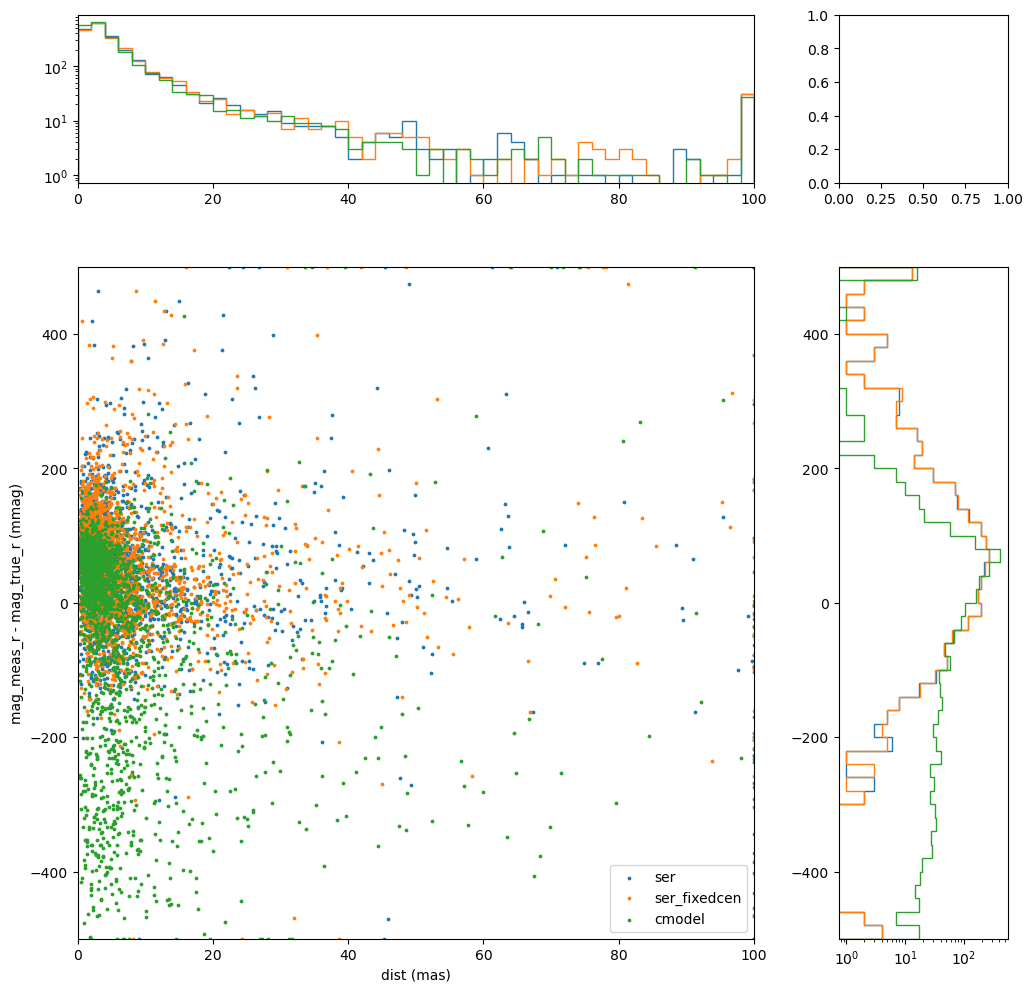

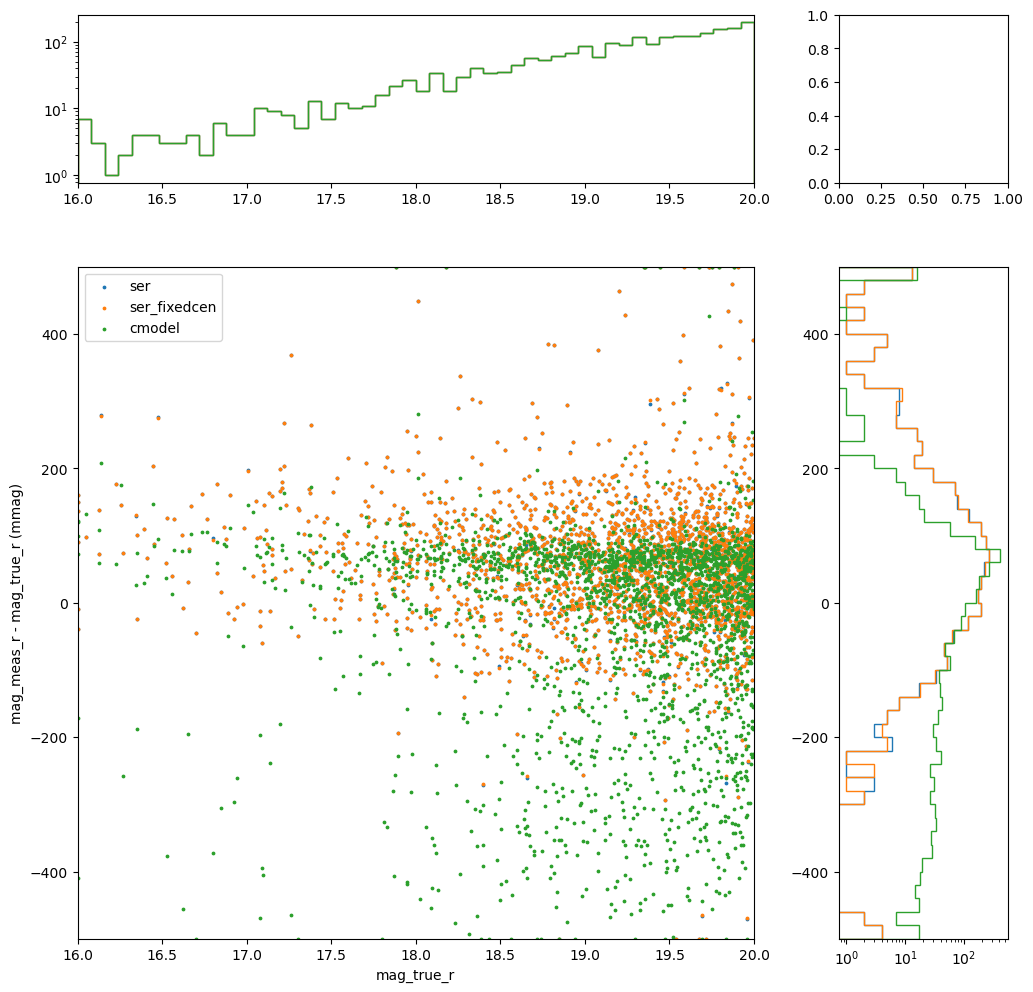

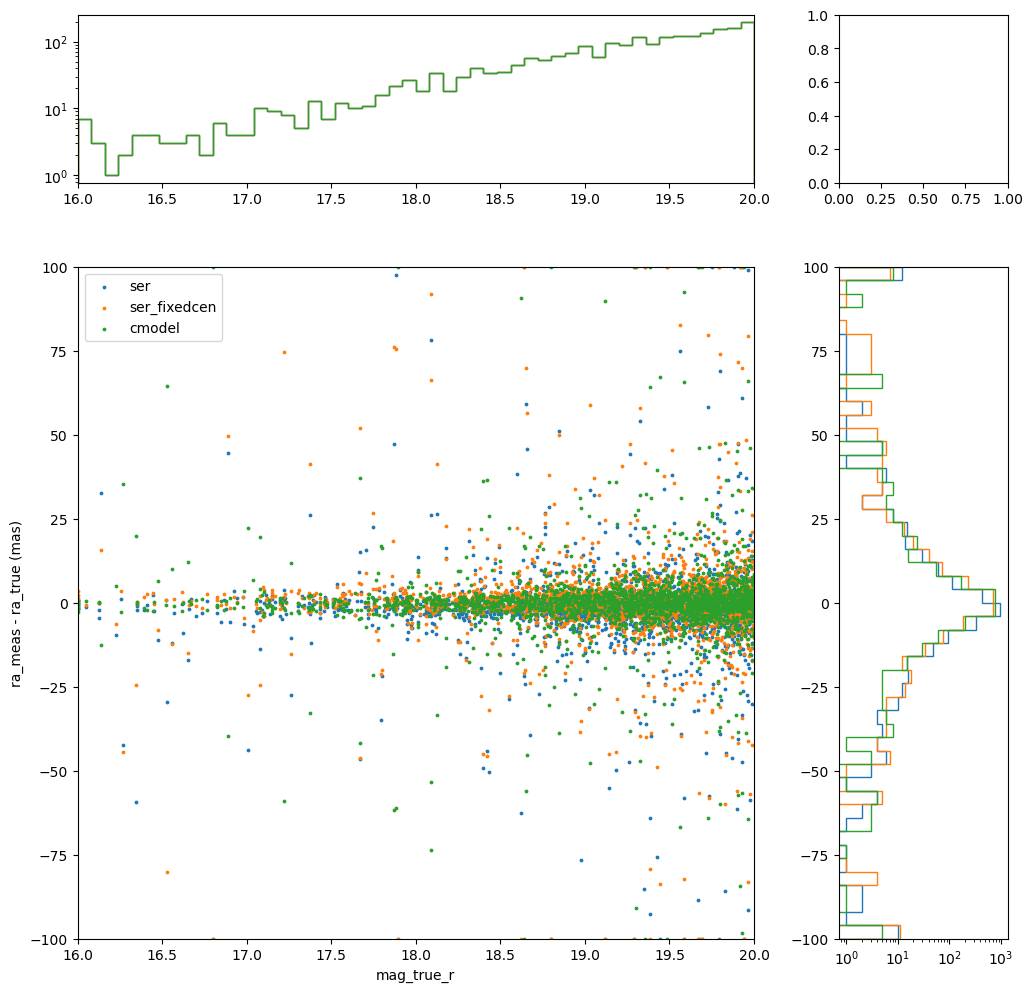

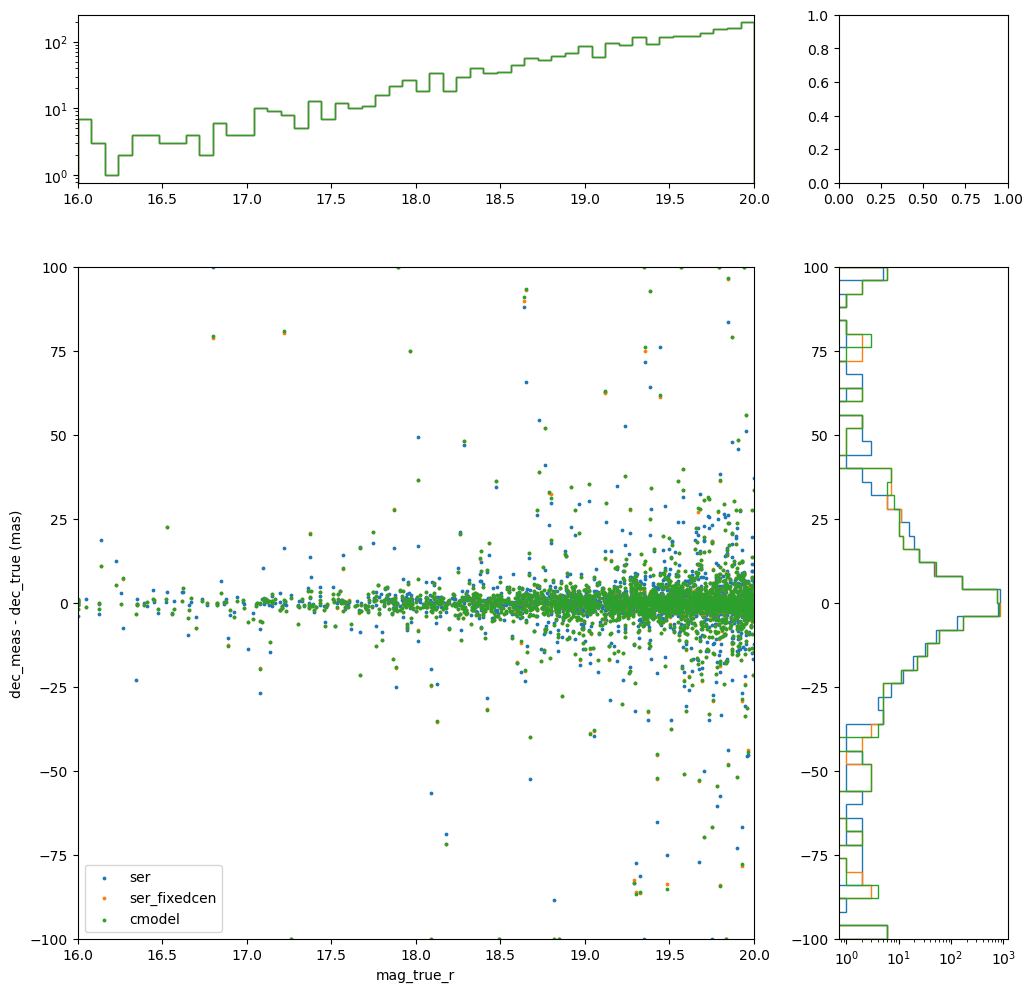

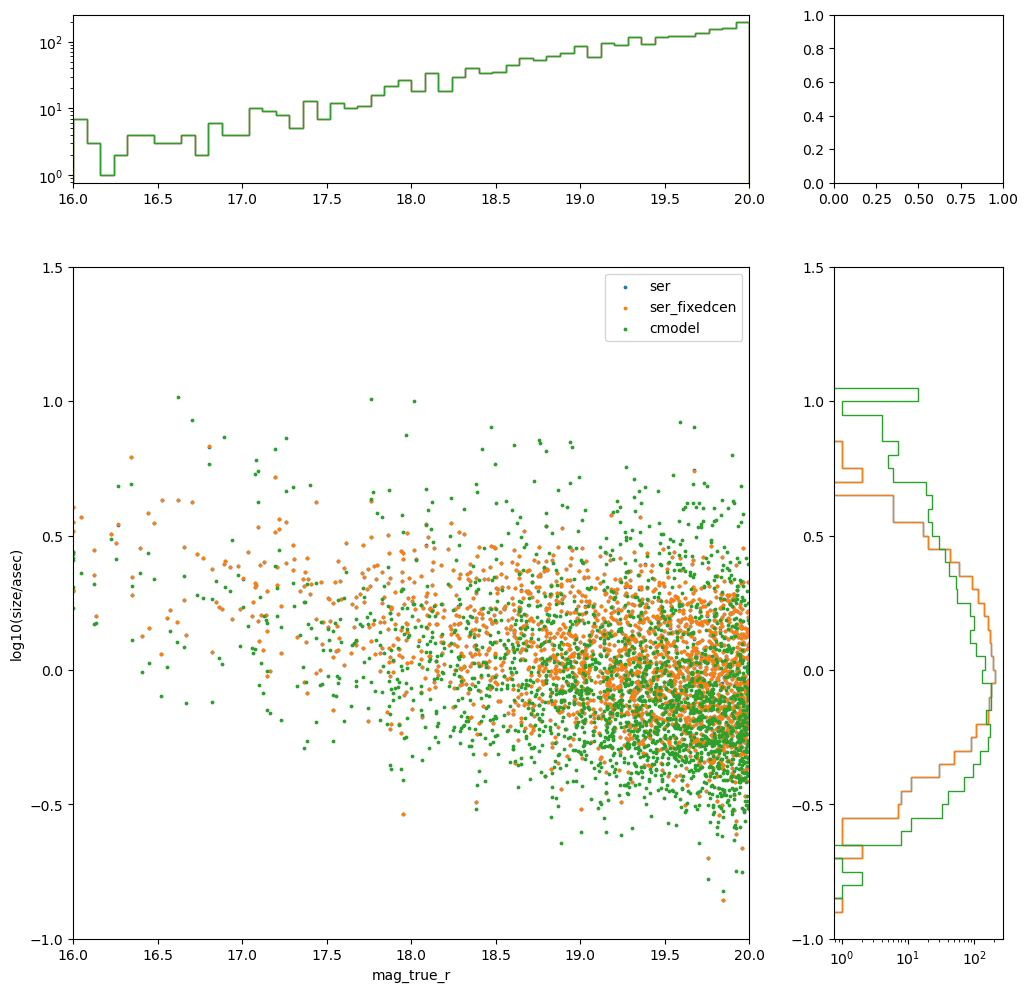

In [35]:
# true galaxies
galaxies_true = get_bright(matched, scale_pix, (-np.Inf, mag_max), is_pointsource=0)
figaxes_galaxies_true = make_scatterplots(galaxies_true, lims_log_size=(-1, 1.2))

ser          N=2663 med,sig_mad_mag=5.2, 3.2 mmag med,sig_mad_ra=0.91,2.69 mas  med,sig_mad_dec=-0.05,0.73 mas
ser_fixedcen N=2663 med,sig_mad_mag=5.2, 3.2 mmag med,sig_mad_ra=0.26,1.46 mas  med,sig_mad_dec=0.03,0.96 mas
cmodel       N=2663 med,sig_mad_mag=1.6, 2.7 mmag med,sig_mad_ra=-0.21,1.17 mas  med,sig_mad_dec=0.03,0.96 mas


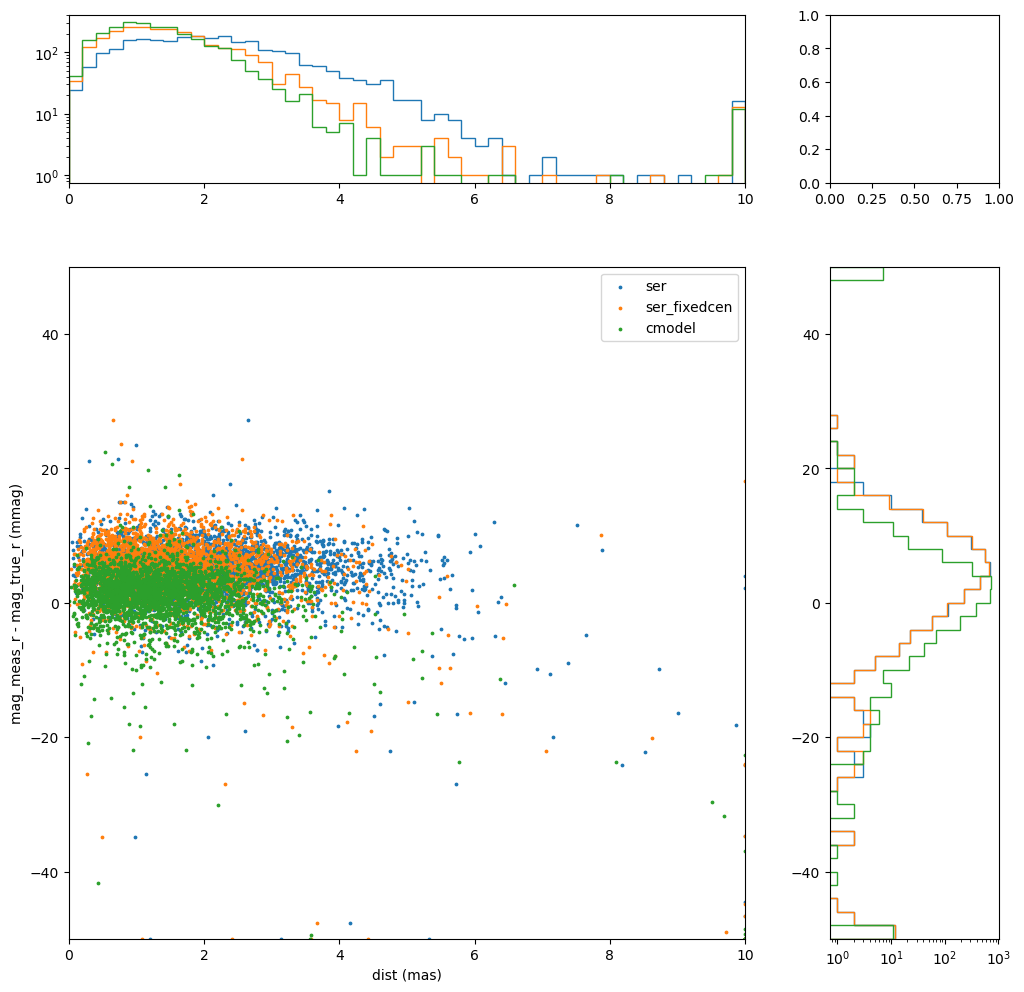

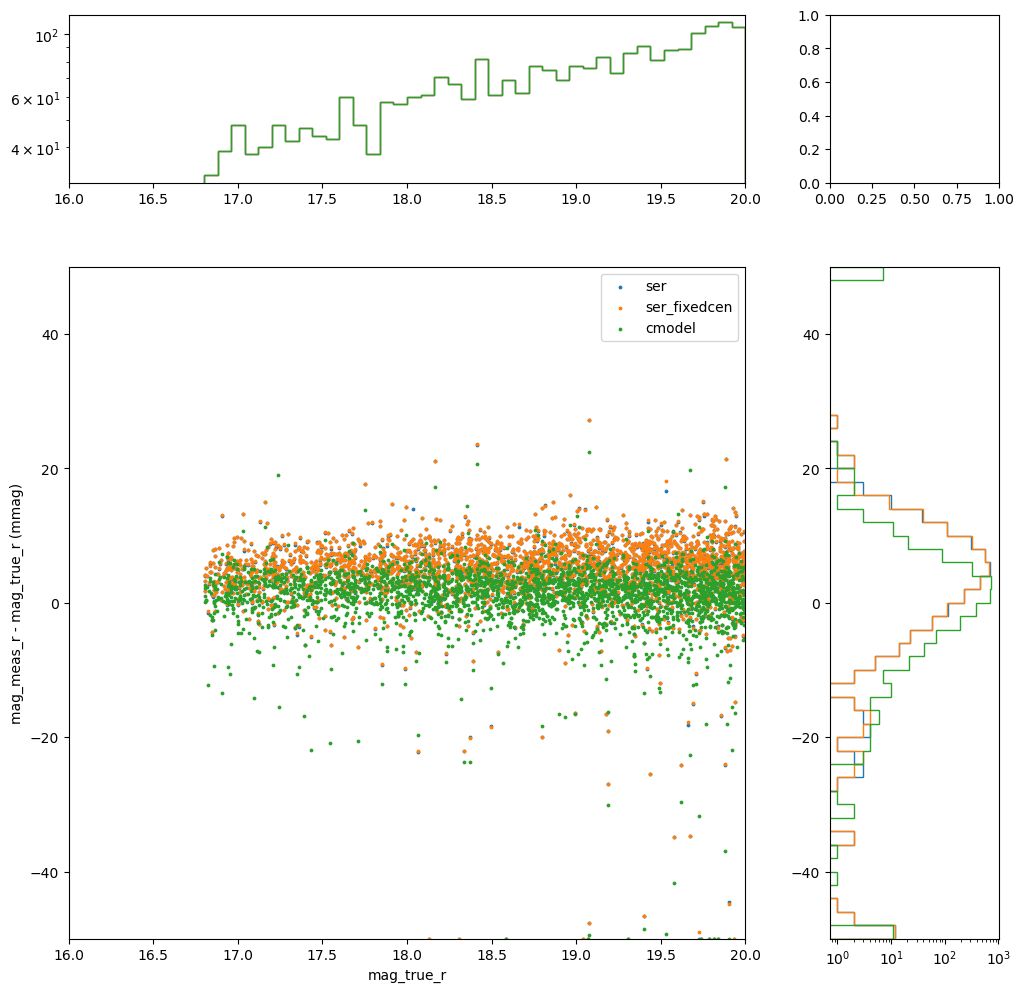

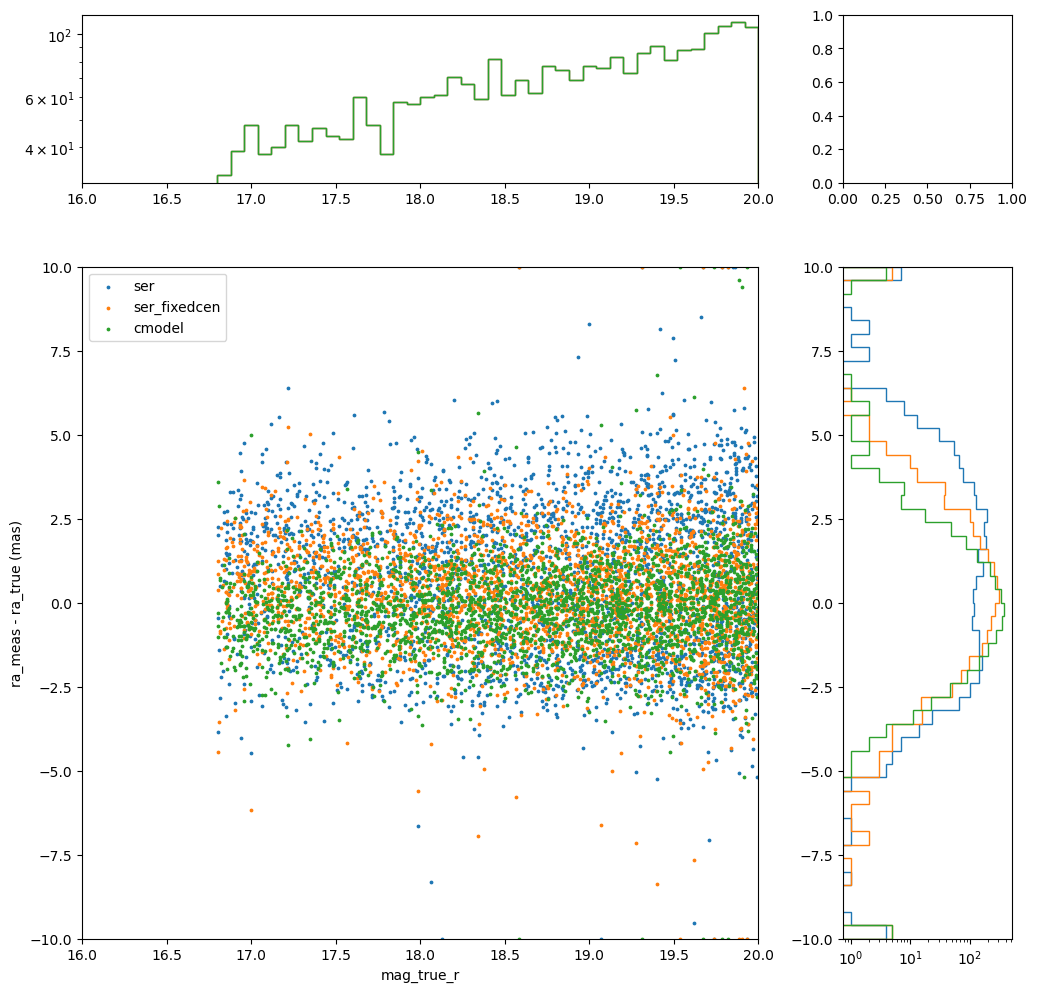

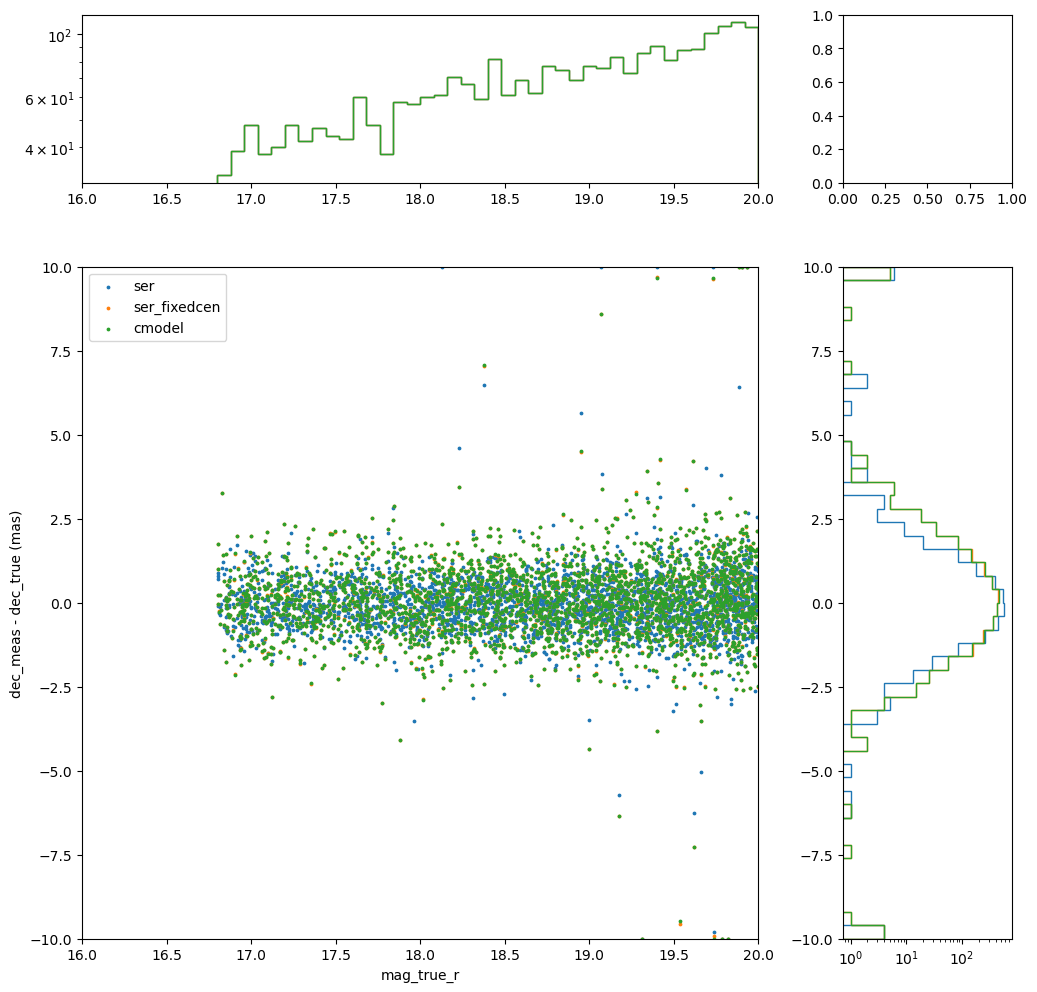

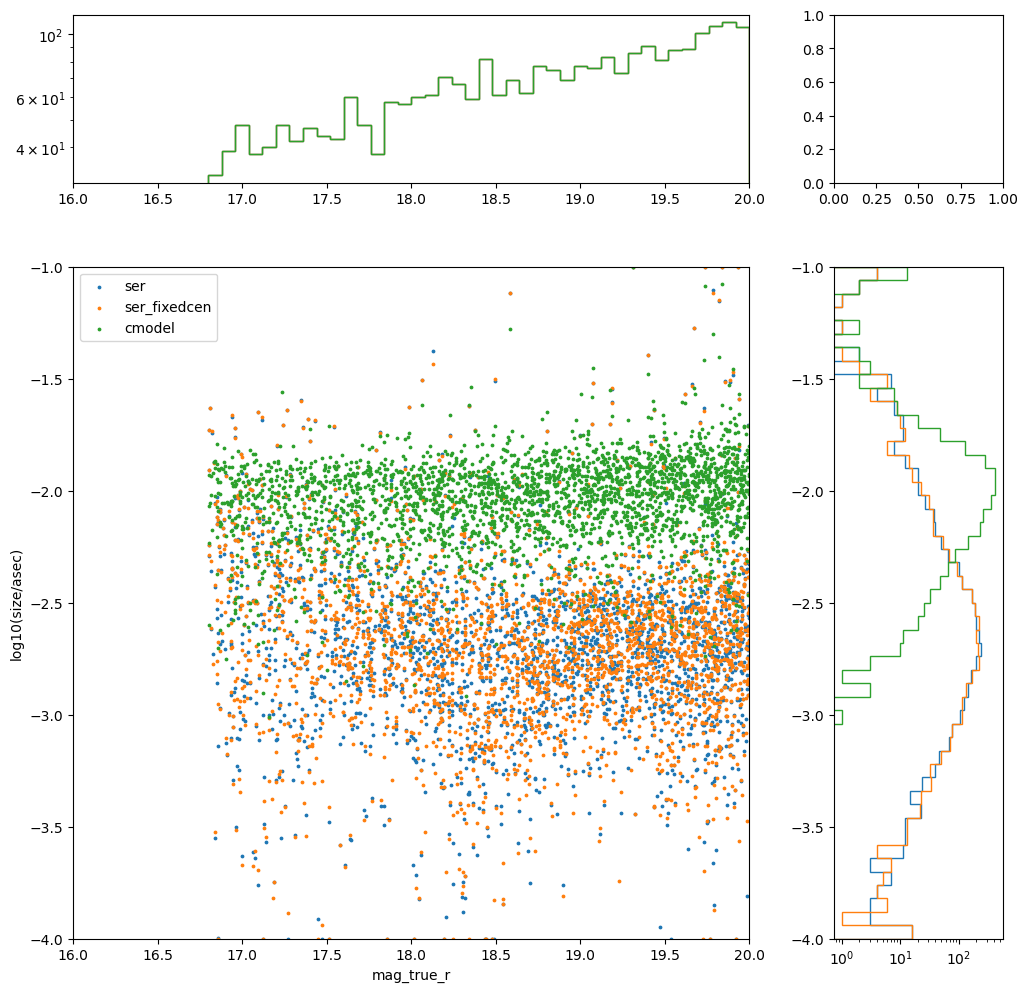

In [37]:
# true stars
kwargs_star = dict(lims_dist=(0, 10.), lims_mag_diff=(-50, 50), lims_log_size=(-4, -1))
stars_true = get_bright(matched, scale_pix, (16.8, mag_max), is_pointsource=1)
figaxes_stars_true = make_scatterplots(stars_true, **kwargs_star)

ser          N=2264 med,sig_mad_mag=57.1, 77.4 mmag med,sig_mad_ra=-1.61,3.67 mas  med,sig_mad_dec=0.11,2.67 mas
ser_fixedcen N=2257 med,sig_mad_mag=57.1, 77.4 mmag med,sig_mad_ra=0.07,4.02 mas  med,sig_mad_dec=-0.18,3.13 mas
cmodel       N=2257 med,sig_mad_mag=23.0, 81.5 mmag med,sig_mad_ra=-0.06,3.21 mas  med,sig_mad_dec=-0.18,3.13 mas


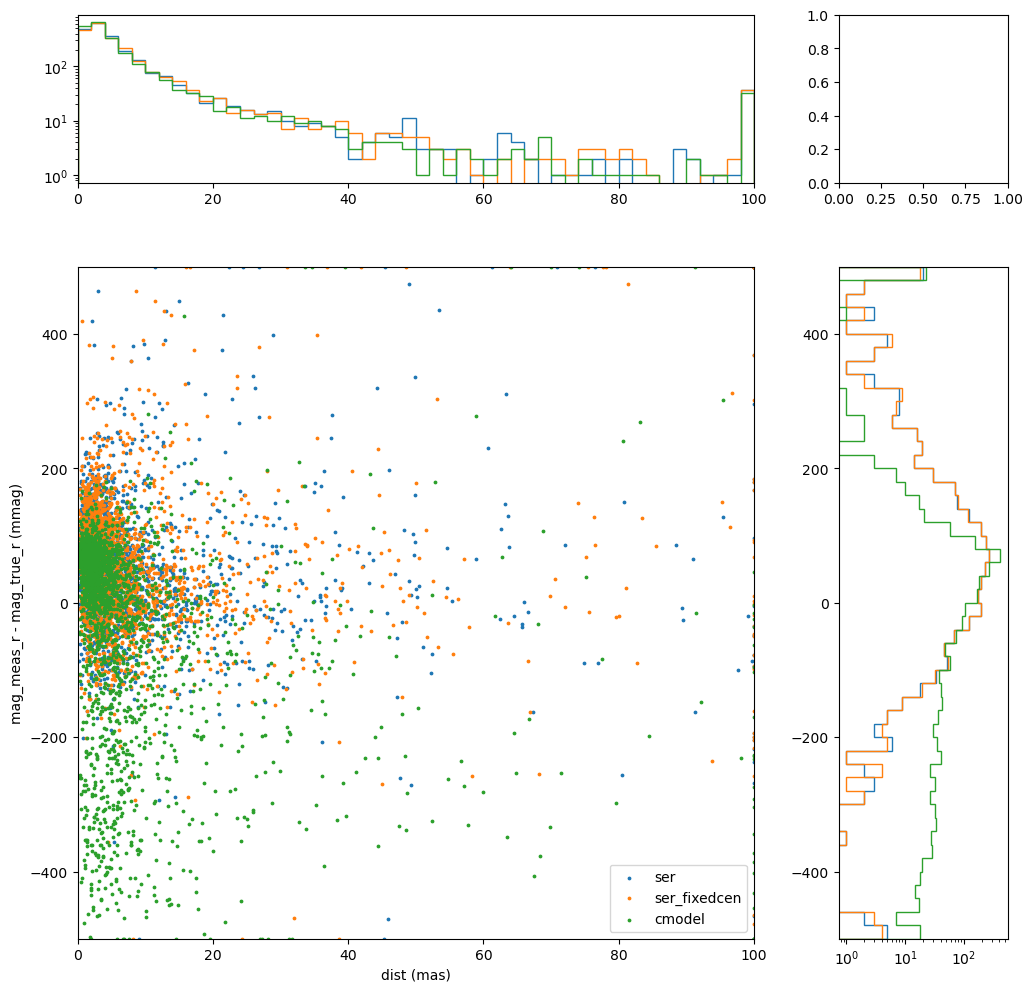

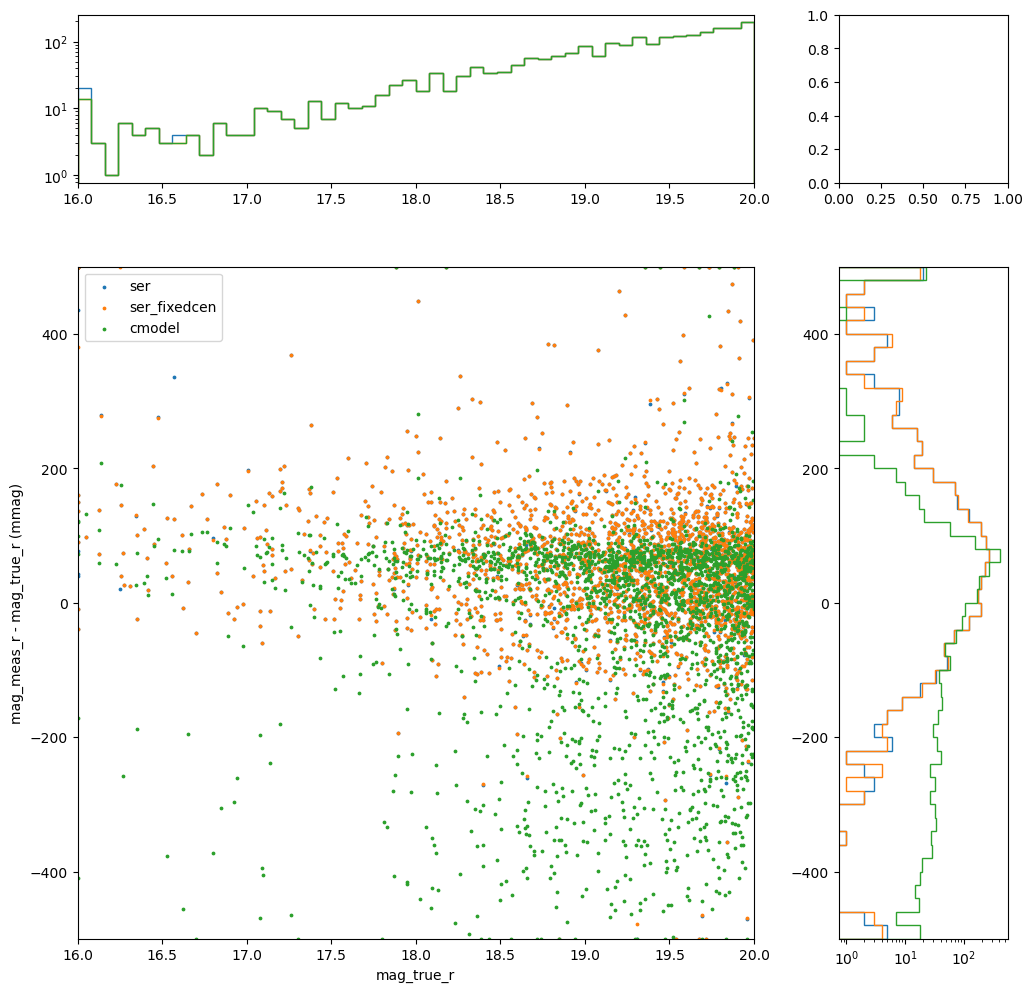

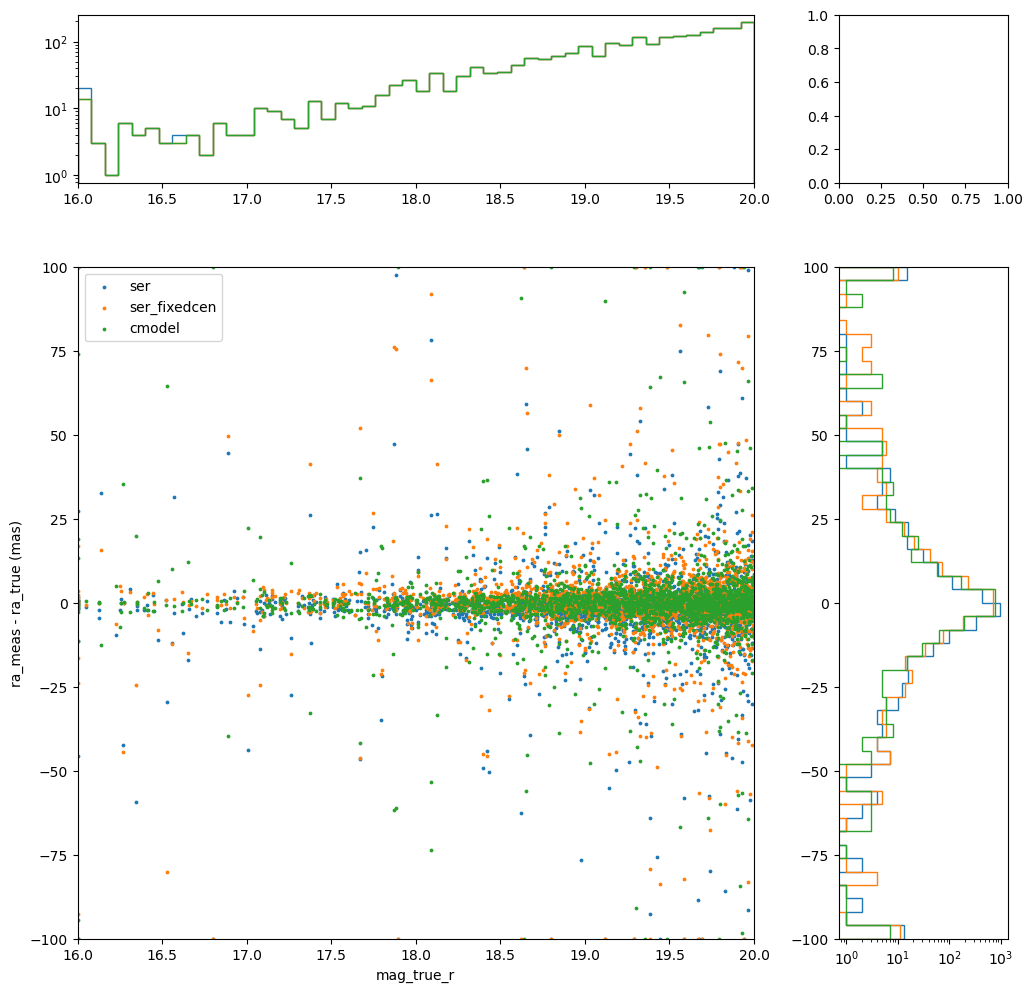

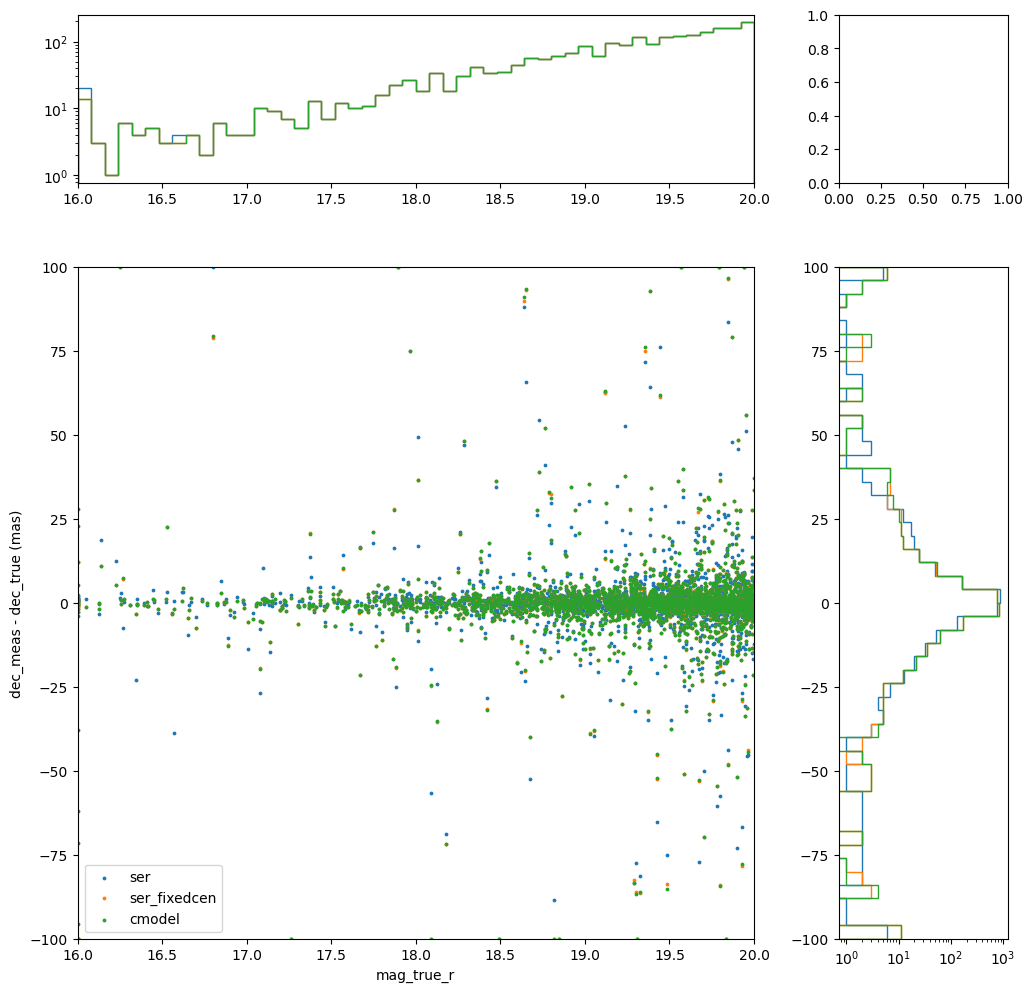

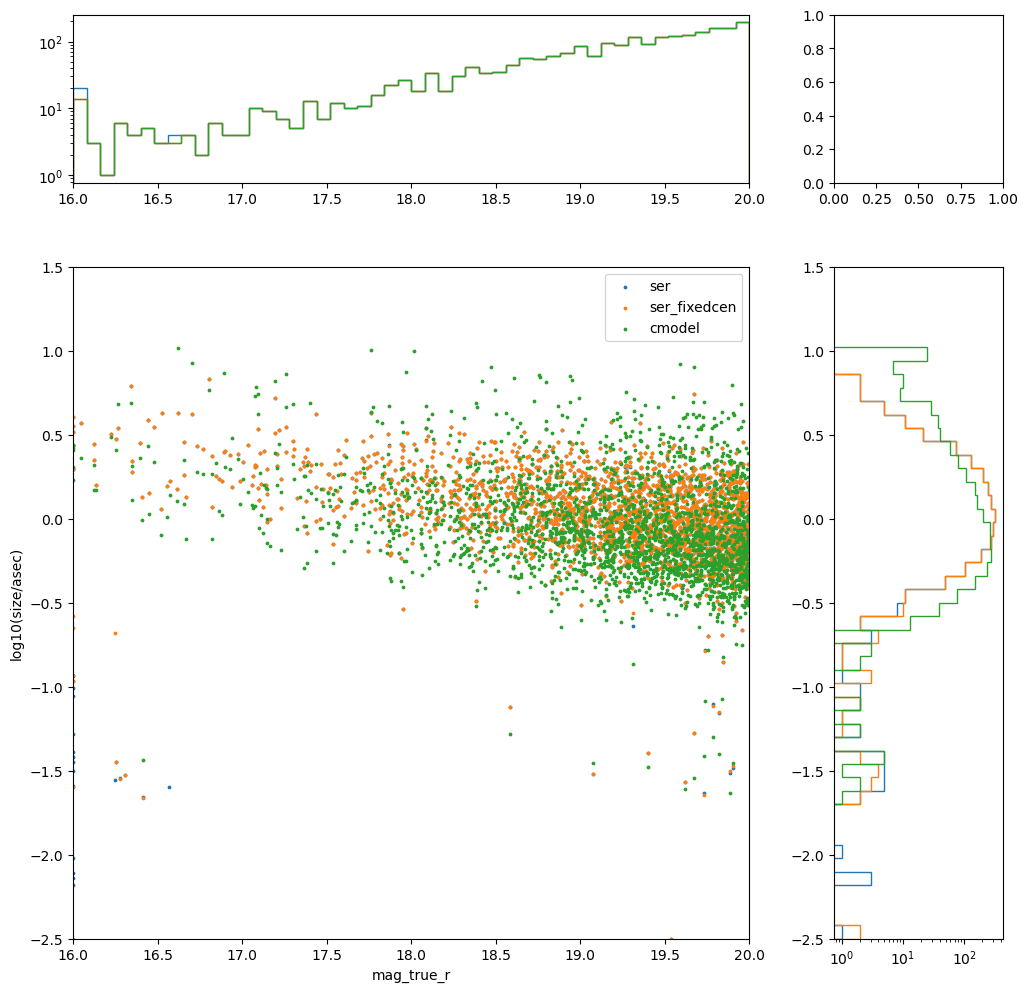

In [38]:
# refExtended >= 0.5 galaxies
galaxies_class = get_bright(matched, scale_pix, (-np.Inf, mag_max), extended_minmax=(0.5, 1.0))
figaxes_galaxies_class = make_scatterplots(galaxies_class)

ser          N=3684 med,sig_mad_mag=6.3, 4.8 mmag med,sig_mad_ra=1.01,2.97 mas  med,sig_mad_dec=-0.03,0.86 mas
ser_fixedcen N=3447 med,sig_mad_mag=6.0, 4.3 mmag med,sig_mad_ra=0.19,1.62 mas  med,sig_mad_dec=0.05,1.07 mas
cmodel       N=3449 med,sig_mad_mag=--, 3.7 mmag med,sig_mad_ra=-0.15,1.30 mas  med,sig_mad_dec=0.05,1.07 mas


/lscratch/dtaranu/ipykernel_3242794/1364915844.py:26: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  f"{model:<12} N={len(diff_mag)} med,sig_mad_mag={np.nanmedian(diff_mag):.1f}, {nanSigmaMad(diff_mag):.1f} mmag"


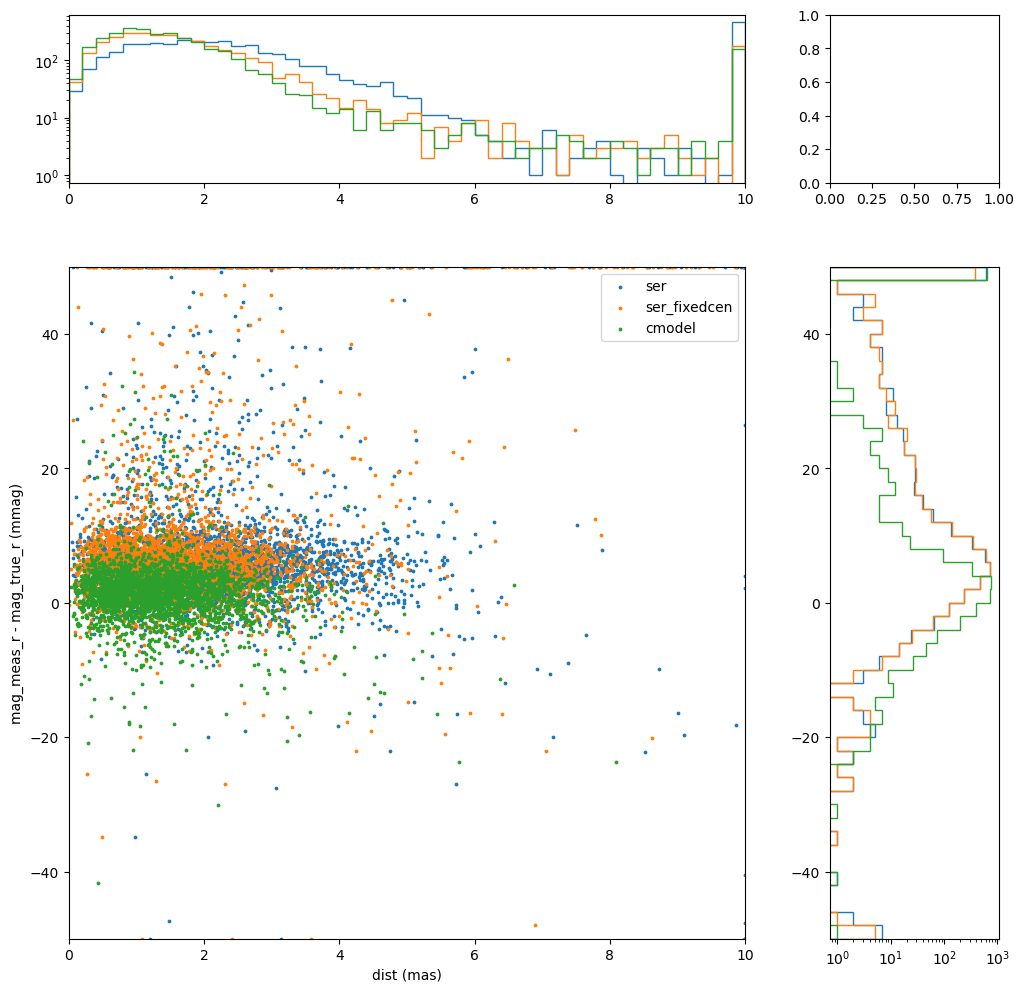

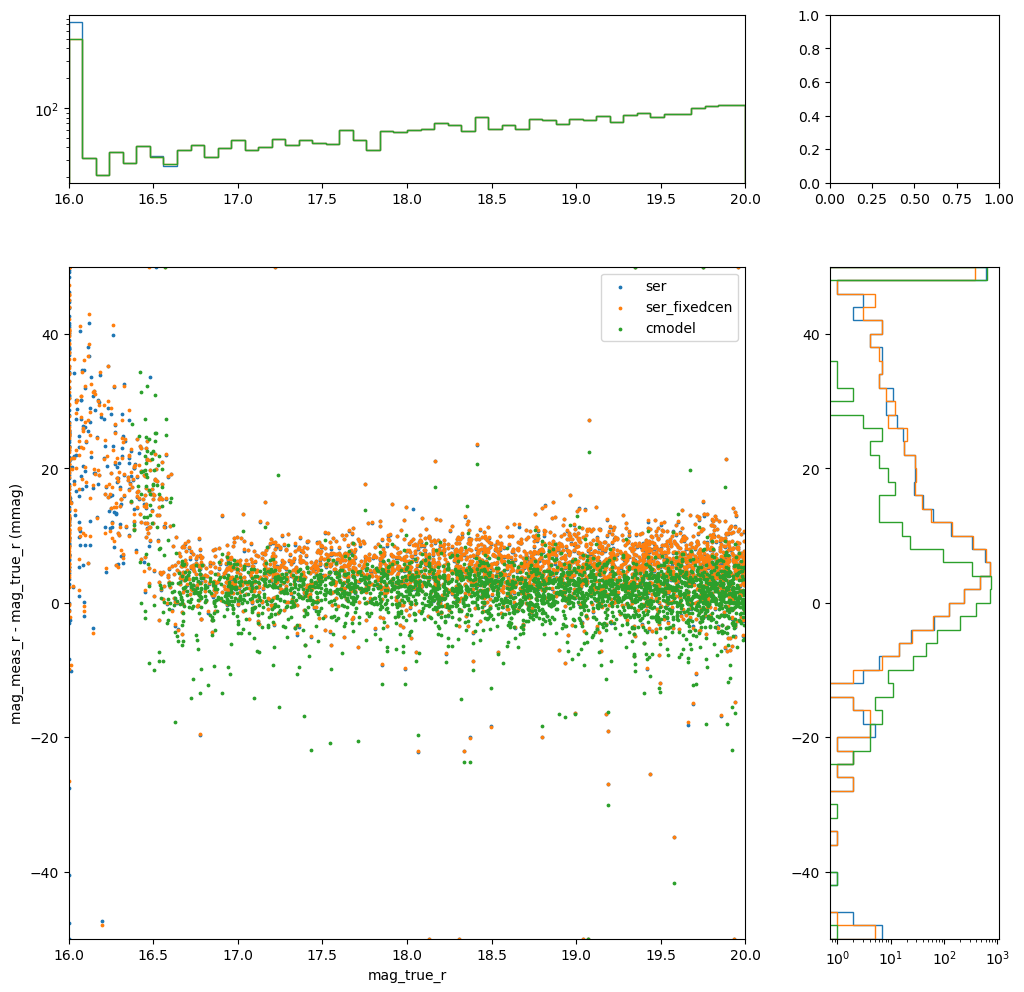

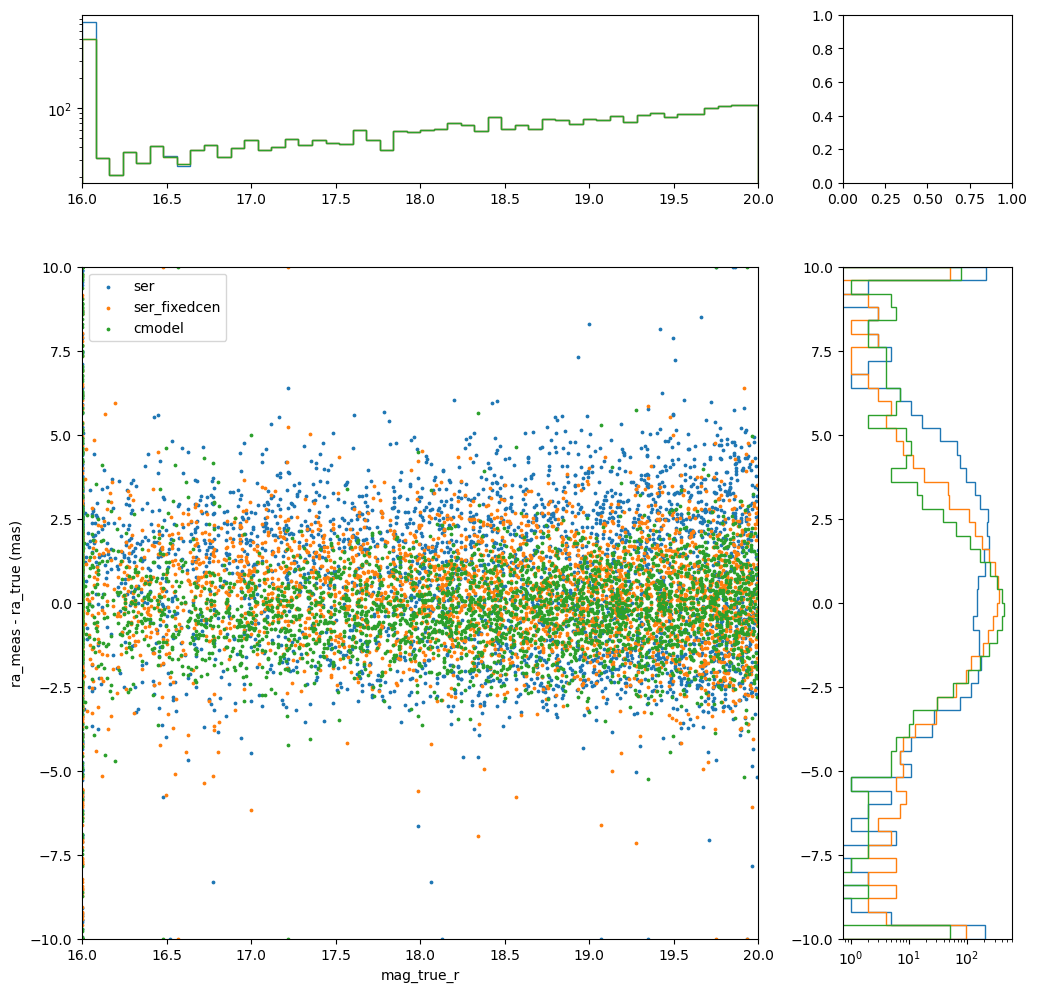

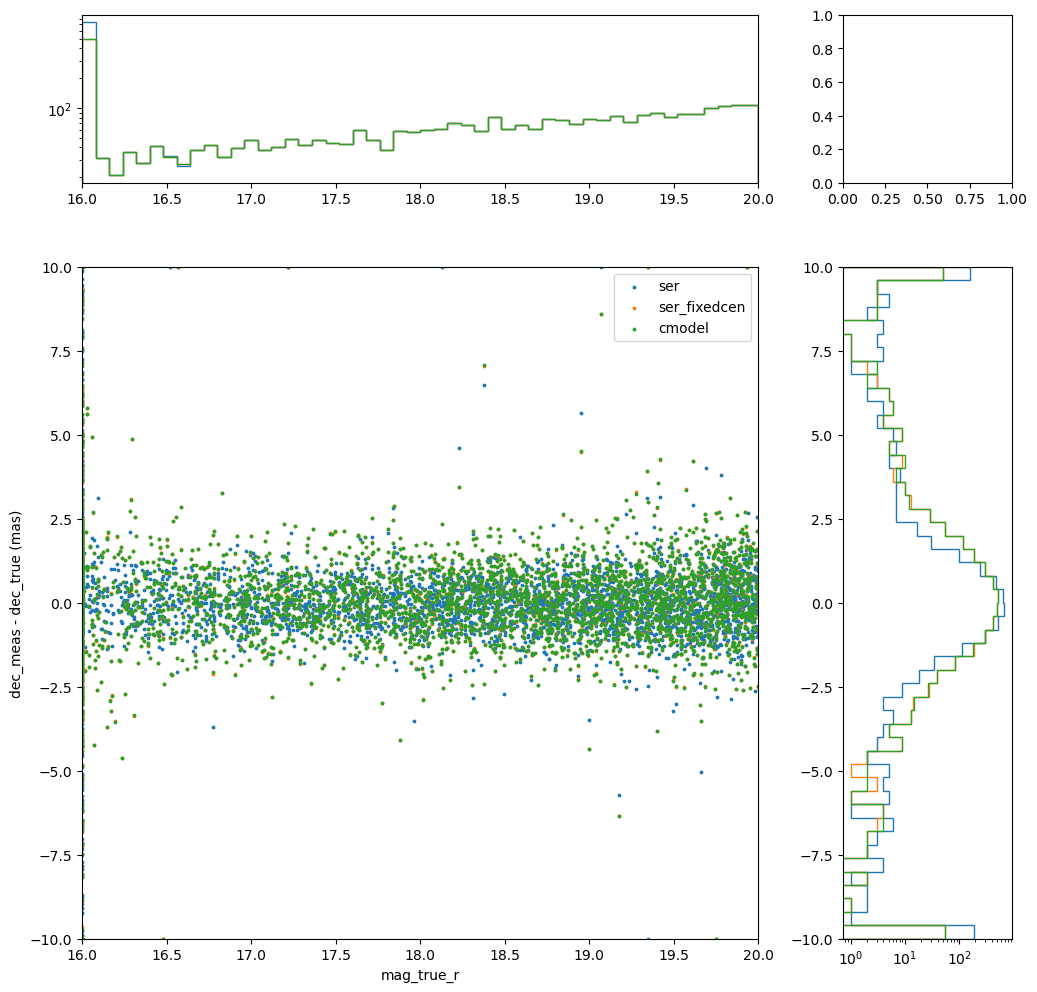

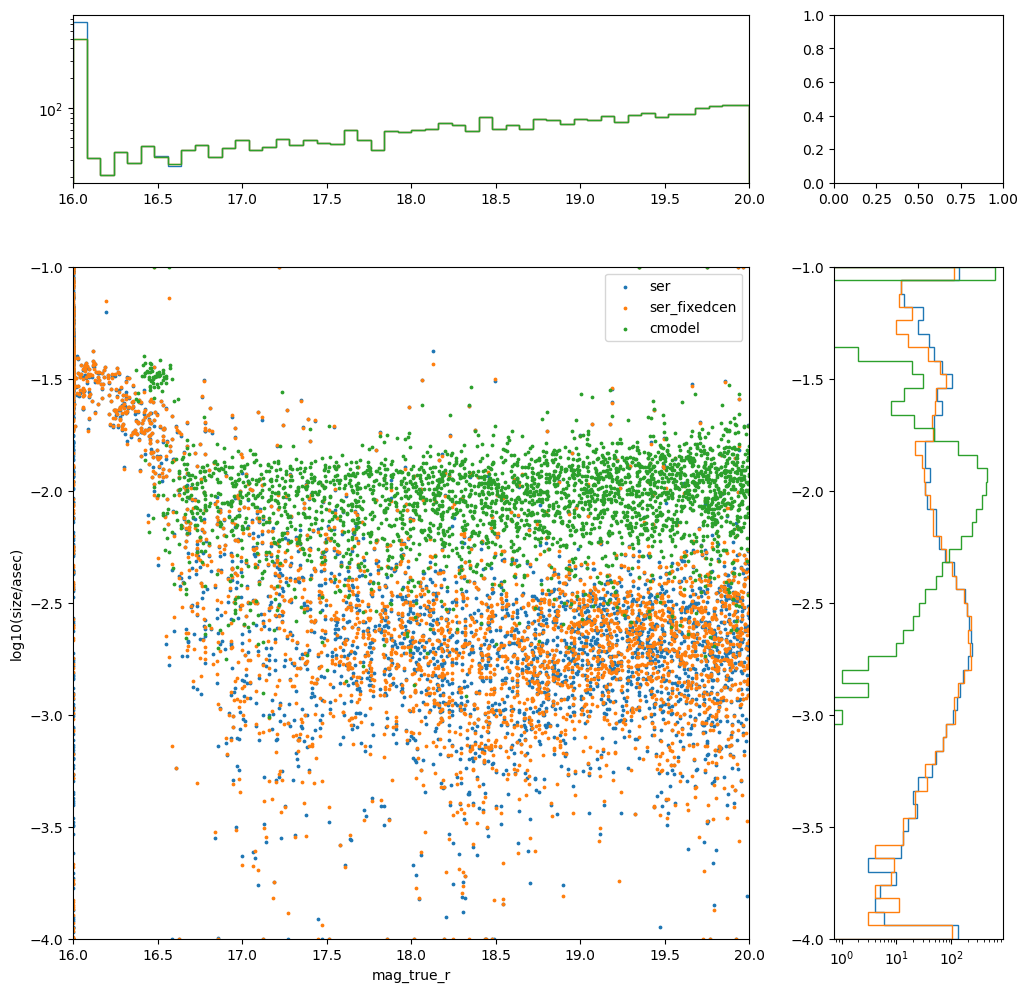

In [39]:
# refExtended stars
stars_class = get_bright(matched, scale_pix, (-np.Inf, mag_max), extended_minmax=(0.0, 0.5))
figaxes_stars_class = make_scatterplots(stars_class, **kwargs_star)